# Personalized Melanoma Staging Model

The goal of this project is to create an easily understood and used tool for doctors to predict whether patients need a sentinel lymph node biopsy (SLNB). SLNB are an invasive procedure and currently doctors suggest it to patients if there is around a 10% chance for a positive biopsy. These odds are mostly based upon the depth of the melanoma, so I would like to use more data in order to create better predictions for the odds that patients need the biopsy. 

## The Data
I am using data from two sources: the National Cancer Database and the NIH's SEER Database. Currently, we are soley focusing on the NCDB's melanoma patients.

In [269]:
import pandas as pd
import  psycopg2 as sql

#mela = pd.read_csv('Melanoma.csv')
sql_mela = sql.connect(host="localhost", user="karenlarson", dbname="melanoma")
#attribs = ['AGE', 'SEX', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
 #          'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'CS_SITESPECIFIC_FACTOR_3']


In [270]:
query = """SELECT "AGE", "SEX", "DEPTH", "ULCERATION", "MITOSES", "CS_EXTENSION", "PRIMARY_SITE", "CS_LYMPH_NODE_METS"
            FROM melanoma"""
#query = """SELECT "AGE", "SEX", "DEPTH", "ULCERATION", "MITOSES", "CS_EXTENSION", "PRIMARY_SITE", "CS_LYMPH_NODE_METS"
#           FROM melanoma
#           WHERE ("DEPTH" <= 400 AND "DEPTH" >= 100)
#           OR (("DEPTH" < 100 AND "DEPTH" >= 75) AND
#           ("ULCERATION" >= 1 OR "MITOSES" >= 1 OR "AGE" < 40 )) OR 
#           (("DEPTH" < 75 AND "DEPTH" >= 54) AND 
#           (("MITOSES" >= 1 AND "ULCERATION" >= 1) OR ("ULCERATION" >= 1
#           AND "AGE" < 40) OR ("MITOSES" >= 1 AND "AGE" < 40)));"""

In [271]:
mela = pd.read_sql_query(query, sql_mela)

In [272]:
mela.info()
data = mela.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860205 entries, 0 to 860204
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   AGE                 860205 non-null  int64  
 1   SEX                 860205 non-null  int64  
 2   DEPTH               860201 non-null  float64
 3   ULCERATION          860202 non-null  float64
 4   MITOSES             854683 non-null  float64
 5   CS_EXTENSION        860202 non-null  float64
 6   PRIMARY_SITE        860205 non-null  object 
 7   CS_LYMPH_NODE_METS  860202 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 52.5+ MB


As we can see, we have 523492 patients with 126 features (or attributes). Since it is a database, not all of these attributes would be known before a SLNB would be suggested and others of them would be irrelevant to the need for a biopsy. For example, <code>PUF_FACILITY_ID</code> (or the facility where these data were recorded) likely doesn't influence a patient's need for a biopsy. I will use the following subset of features below:

- <code>AGE</code>: The age of the patient
- <code>SEX</code>: The sex of the patient
- <code>RACE</code>: The race of the patient
- <code>SPANISH_HISPANIC_ORIGIN</code>: Indicates whether a patient is hispanic
- <code>CS_SITESPECIFIC_FACTOR_1</code>: The depth of the tumor. I rename this feature <code>DEPTH</code> to be more easily interpable
- <code>CS_SITESPECIFIC_FACTOR_2</code>: The formation of an ulcer on the skin. I rename this feature <code>ULCERATION</code> to be more easily interpable
- <code>CS_EXTENSION</code>: Indicates the extent of the spread of the melanoma.
- <code>CS_SITESPECIFIC_FACTOR_7</code>: Categories for the number of mitoses per square mm around a "hot spot". I rename this feature to <code>MITOSES</code> for interprability.
- <code>PRIMARY_SITE</code>: The main site for the melanoma. The options are:
    - <code>C44.0</code>: Skin of lips, NOS
    - <code>C44.1</code>: Eyelid
    - <code>C44.2</code>: External Ear
    - <code>C44.3</code>: Skin of other and unspecified parts of face
    - <code>C44.4</code>: Skin of scalp and neck
    - <code>C44.5</code>: Skin of the trunk
    - <code>C44.6</code>: Skin of upper limb and shoulder
    - <code>C44.7</code>: Skin of lower limb and hip
    - <code>C44.8</code>: Overlapping lesion of skin
    - <code>C44.9</code>: Skin, NOS
 
We are trying to calssify the patients into whether they had a positive lymph node biopsy or not. This is recorded in <code>TNM_PATH_N</code> or <code>REGIONAL_NODES_POSITIVE</code>.

In [273]:
#mela['TNM_PATH_N'].value_counts()

## Data Cleaning and Feature Combining

Some of the rows of the features are missing data. To start with, I will drop rows with missing data in order to have the best possible training data possible. This is a reasonable assumption currently because I have a large amount of training data, but I can work on creating a model including interpolation at a later point.

In [274]:
#attribs = ['AGE', 'SEX', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
     #      'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'CS_SITESPECIFIC_FACTOR_3']
#num_attribs = ['AGE', 'SEX', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
      #     'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'CS_SITESPECIFIC_FACTOR_3']
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'REGIONAL_NODES_POSITIVE']
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

#attribs = ['AGE', 'SEX', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

In [275]:
#data = mela[attribs].dropna()
#data[num_attribs] = data[num_attribs].apply(pd.to_numeric, errors='coerce')
#data.info()

In [276]:
#data['SPANISH_HISPANIC_ORIGIN'].value_counts() #9 means unknown if HISPANIC, 99 FOR RACE MEANS RACE UNKNOWN

In [277]:
#data = data.rename(columns={'CS_SITESPECIFIC_FACTOR_1': "DEPTH", 'CS_SITESPECIFIC_FACTOR_2': 'ULCERATION',
 #      'CS_SITESPECIFIC_FACTOR_7': 'MITOSES', 'CS_SITESPECIFIC_FACTOR_3': 'CS_LYMPH_NODE_METS'})

In [278]:
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'DEPTH', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'REGIONAL_NODES_POSITIVE']
#attribs = ['AGE', 'SEX',  'DEPTH', 'ULCERATION',
  #      'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'CS_LYMPH_NODE_METS']

#attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

### Dropping Missing Values
For most of our attributes, a missing value is coded as 999. We care remove these entries easily by using .dropna(). However, I need to do additional cleaning for each of our attributes.

In [279]:
#data['CS_LYMPH_NODE_METS'] = data['CS_LYMPH_NODE_METS'].replace([5, 10],[0, 1])
#data = data[data['CS_LYMPH_NODE_METS'] <= 1.5]
##data['CS_LYMPH_NODE_METS'].value_counts()
#print(data['TNM_PATH_N'].value_counts())
#
#import numpy as np
##data['TNM_PATH_N'] = data['TNM_PATH_N'].replace(['p0', 'pX', 'p1A', 'p2A', 'p1', 'p3', 'p2C', 'p2', 'p1B', 'p2B', '88'], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])
#
#print(data['TNM_PATH_N'].value_counts())
#
#print(sum(data['CS_LYMPH_NODE_METS']))
#print(sum(data['TNM_PATH_N']))
#data['REGIONAL_NODES_POSITIVE'] = data['REGIONAL_NODES_POSITIVE'].replace([98, 99], [0, 0])
#data['POSITIVE'] = np.where(data['TNM_PATH_N'] + data['CS_LYMPH_NODE_METS'] + data['REGIONAL_NODES_POSITIVE'] > 0, 1, 0)
#print(sum(data['POSITIVE']))

In [325]:
new_df = data[(data != 999).all(1)]
new_df = new_df[(new_df != 1022).all(1)]
new_df = new_df[new_df['DEPTH'] != 980]
#new_df = new_df[new_df['DEPTH'] <= 400]


#new_df = new_df[new_df['SPANISH_HISPANIC_ORIGIN'] != 9]
new_df = new_df[new_df['MITOSES'] != 988]

#new_df.info()
new_df.tail()

,AGE,SEX,DEPTH,ULCERATION,MITOSES,CS_EXTENSION,PRIMARY_SITE,CS_LYMPH_NODE_METS
860085,81,1,89.0,0.0,0.0,300.0,442,5.0
860086,51,1,50.0,0.0,0.0,200.0,446,5.0
860087,53,1,42.0,0.0,0.0,100.0,446,5.0
860159,40,2,34.0,0.0,0.0,100.0,445,5.0
860170,34,2,88.0,0.0,1.0,300.0,447,5.0


### Combining Feature Values
For some of our features, there have been two coding schema. For example, `ULCERATION` = 1.0 and `ULCERATION` = 10.0 both correspond to the presence of ulceration. Below, we combine our features in order to better represent the data.

In [326]:
new_df['ULCERATION'] = new_df['ULCERATION'].replace(10.0, 1.0)
new_df['ULCERATION'].value_counts()

0.0    203406
1.0     38163
Name: ULCERATION, dtype: int64

The `CS_EXTENSION` attribute has a combination of features for the depth of the extension as well as the Clark Level. For now, I have removed anything that isn't about the Clark Level of the tumor.

In [327]:
print(new_df['CS_EXTENSION'].value_counts())
new_df['CS_EXTENSION'] = new_df['CS_EXTENSION'].replace([
    310, 315, 320, 330, 335, 340, 350, 355, 360, 370, 375, 380, 400, 800, 950],
    [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 800, 999])
new_df = new_df[(new_df != 999).all(1)]
new_df['CS_EXTENSION'].value_counts()

300.0    84144
100.0    58838
200.0    46192
400.0    12158
310.0     9927
500.0     9024
0.0       4736
330.0     3759
315.0     3033
350.0     1804
375.0     1768
355.0     1479
950.0     1167
335.0     1041
370.0     1011
320.0      475
360.0      280
380.0      273
340.0      251
800.0      209
Name: CS_EXTENSION, dtype: int64


300.0    84144
100.0    58838
200.0    46192
500.0     9024
0.0       4736
800.0      209
Name: CS_EXTENSION, dtype: int64

In [283]:
#new_df['REGIONAL_NODES_POSITIVE'] = new_df['REGIONAL_NODES_POSITIVE'].replace(98, 0)
#new_df['REGIONAL_NODES_POSITIVE'].value_counts()
#new_df = new_df[(new_df['REGIONAL_NODES_POSITIVE'] != 99)]

#new_df['REGIONAL_NODES_POSITIVE'] = new_df['REGIONAL_NODES_POSITIVE'] > 0 
#new_df['REGIONAL_NODES_POSITIVE'].value_counts()

In [328]:
new_df['CS_LYMPH_NODE_METS'] = new_df['CS_LYMPH_NODE_METS'].replace([5, 10],[0, 1])
new_df = new_df[new_df['CS_LYMPH_NODE_METS'] <= 1.5]
new_df['CS_LYMPH_NODE_METS'].value_counts()


0.0    185344
1.0     12214
Name: CS_LYMPH_NODE_METS, dtype: int64

In [285]:
#new_df['TNM_PATH_N'].value_counts()
#new_df = new_df[new_df['TNM_PATH_N'] != '88']
#new_df = new_df[new_df['TNM_PATH_N'] != 'pX']

#new_df['TNM_PATH_N'].value_counts()
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: 0 if x == 'pX' else x)
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: 0 if x == 'p0' else 1)
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: x if x == 0 or x == 1 else 1)


In [286]:
#new_df['TNM_PATH_N'].value_counts()

For the `RACE` attribute, there are several demographics that we only have a single representative; for simplicity, we split these demographics into white, black, and other and hispanic or not hispanic.

In [287]:
#import numpy as np
#new_df['RACE'].value_counts()
#a = np.array(new_df['RACE'].values.tolist())
#new_df['RACE'] = np.where(a > 2, 3, a).tolist()
#new_df['RACE'].value_counts()#new_df['RACE'] = new_df['RACE'].apply(lambda x: [y if y <= 1 else 2 for y in x])
##new_df['RACE']
#
#a = np.array(new_df['SPANISH_HISPANIC_ORIGIN'].values.tolist())
#new_df['SPANISH_HISPANIC_ORIGIN'] = np.where(a > 1, 1, a).tolist()
#new_df['SPANISH_HISPANIC_ORIGIN'].value_counts()

The other feature used is the `PRIMARY_SITE`, which codes where the melanoma is located. The features are fairly specific, so for now I coarse grain this into three categories: Head and neck, Trunk, or Extremity.

Current labels are

- `c440`: Skin of lip -> Head or Neck
- `c441`: Eyelid -> Head or Neck
- `c442`: External ear -> Head or Neck
- `c443`: Skin of other and unspecified parts of face -> Head or Neck
- `c444`: Skin of scalp and neck -> Head or Neck
- `c445`: Skin of trunk -> Trunk
- `c446`: Skin of upper limb and shoulder -> Extremity
- `c447`: Skin of lower limb and hip -> Extremity
- `c448`: Overlapping lesion of skin -> ?
- `c449`: Skin, NOS -> ?

In [288]:
#new_df['DEPTH_3'] = new_df['DEPTH'] ** 3

In [329]:
import numpy as np
new_df['PRIMARY_SITE'].value_counts()
new_df['PRIMARY_SITE'] = new_df['PRIMARY_SITE'].replace([
    'C440', 'C441', 'C442', 'C443', 'C444', 'C445', 'C446', 'C447', 'C448', 'C449'],
    #[0,1,2,3,4,5, 6,7,999,999])
    [0,0,0,0,0,1, 2,2,999,999])
new_df['PRIMARY_SITE'] = new_df['PRIMARY_SITE'].replace([
    '440', '441', '442', '443', '444', '445', '446', '447', '448', '449'],
    [0,0,0,0,0,1,2,2,999,999])

new_df = new_df[(new_df != 999).all(1)]

new_df['PRIMARY_SITE'].value_counts()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196806 entries, 4 to 860170
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   AGE                 196806 non-null  int64  
 1   SEX                 196806 non-null  int64  
 2   DEPTH               196806 non-null  float64
 3   ULCERATION          196806 non-null  float64
 4   MITOSES             196806 non-null  float64
 5   CS_EXTENSION        196806 non-null  float64
 6   PRIMARY_SITE        196806 non-null  int64  
 7   CS_LYMPH_NODE_METS  196806 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 13.5 MB


In [330]:
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'DEPTH', 'DEPTH_3', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE']

attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION',
            'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE']

X = new_df[attribs]
y = new_df['CS_LYMPH_NODE_METS']
#y = new_df['REGIONAL_NODES_POSITIVE']
print(len(X))
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.10, random_state=20)


#stratifying
tmp = X_cv
tmp['TARGET'] = y
c1 = tmp['DEPTH'] <= 100
c2 = tmp['ULCERATION'] == 0
c3 = tmp['MITOSES'] == 0
c4 = (tmp['DEPTH'] > 100) & (tmp['DEPTH'] <= 200)
c5 = (tmp['DEPTH'] > 200) & (tmp['DEPTH'] <= 400)

T1a = tmp[c1 & c2 & c3]
y1a = T1a['TARGET']
T1a = T1a.drop(columns=["TARGET"])

T1b = tmp[c1 & ~(c2 & c3)]
y1b = T1b['TARGET']
T1b = T1b.drop(columns=["TARGET"])

T2a = tmp[c4 & c2]
y2a = T2a['TARGET']
T2a = T2a.drop(columns=["TARGET"])

T2b = tmp[c4 & ~(c2)]
y2b = T2b['TARGET']
T2b = T2b.drop(columns=["TARGET"])

T3a = tmp[c5 & c2]
y3a = T3a['TARGET']
T3a = T3a.drop(columns=["TARGET"])

T3b = tmp[c5 & ~(c2)]
y3b = T3b['TARGET']
T3b = T3b.drop(columns=["TARGET"])
#T1 = tmp[tmp['DEPTH' <= 100]]


print(sum(y_train)/len(X_train))
print(sum(y_test)/len(X_test))
print(sum(y_cv)/len(X_cv))

196806
0.062025843513362836
0.06142980539606727
0.06147983486821213


## Encoding Attributes

We have a few <b>numerical attributes</b>
- AGE
- DEPTH
- MITOSES
- CS_EXTENSION


<b>Categorical Attributes</b>
- SEX
- RACE
- SPANISH_HISPANIC_ORIGIN
- ULCERATION
- PRIMARY_SITE

In [356]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler



class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]
    
    
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X,y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["AGE","DEPTH", "CS_EXTENSION", "MITOSES"])),
    ('poly', PolynomialFeatures(degree=3)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
     ])

from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(['SEX','ULCERATION', 'PRIMARY_SITE'])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [292]:
corr_matrix = new_df.corr()
corr_matrix["CS_LYMPH_NODE_METS"].sort_values(ascending=False)

CS_LYMPH_NODE_METS    1.000000
DEPTH                 0.258939
CS_EXTENSION          0.213738
ULCERATION            0.195658
SEX                  -0.015521
MITOSES              -0.056798
AGE                  -0.063927
Name: CS_LYMPH_NODE_METS, dtype: float64

In [293]:
train_num = num_pipeline.fit_transform(X_train)
print(len(train_num))

142241


In [294]:
#cat_pipeline.fit_transform(X_train);

### Pre-processing the data

Now, I want to take out the numerical attributes and the categorical attributes and format the data according to the pipeline above. In addition, I split the data again into a cross-validation set in order to better tune the model parameters.

In [357]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

x_train = preprocess_pipeline.fit_transform(X_train)
#print(X_train.head())

#print(len(x_train[0]))
#sc = MinMaxScaler()
#x_train = sc.fit_transform(x_train)
x_cv = preprocess_pipeline.transform(X_cv)
x_test = preprocess_pipeline.transform(X_test)

x_t1a = preprocess_pipeline.transform(T1a)
x_t1b = preprocess_pipeline.transform(T1b)

x_t2a = preprocess_pipeline.transform(T2a)
x_t2b = preprocess_pipeline.transform(T2b)

x_t3a = preprocess_pipeline.transform(T3a)
x_t3b = preprocess_pipeline.transform(T3b)

In [355]:
#print(x_train[0][30:])

[0.e+00 1.e+06 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 1.e+00 0.e+00 0.e+00
 0.e+00 1.e+00]


# Methods for Estimating

Our baseline for estimating is to predict the majority class, i.e. that everyone doesn't need the SLNB. This gives us a point of comparison for the accuracy of our method: we must perform better than this in a meaningful way for our new model to be performing well.

In [296]:
from sklearn.base import BaseEstimator

class BaseLine(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1))

In [297]:
from sklearn.model_selection import cross_val_score
base_line_clf = BaseLine()
base_scores = cross_val_score(base_line_clf,x_train,y_train,cv=10,scoring="accuracy")
base_scores.mean()

0.9384495266299094

In [377]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

log_clf = LogisticRegression(solver="liblinear", C = 0.001)
log_clf.fit(x_train,y_train)
#log_scores = cross_val_score(log_clf, x_train,y_train,cv=10,scoring="accuracy")



LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [382]:
THRESHOLD = 0.02
y_pred = np.where(log_clf.predict_proba(x_train)[:,1] > THRESHOLD, 1, 0)
log_score = accuracy_score(y_train,y_pred)
print(log_score)
#log_scores.mean()
print(f"The confusion matrix is {confusion_matrix(y_train,y_pred)}")
importance = log_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
#y_pred = y_pred == 2
#y_simple = y_train == 2
log_f1 = f1_score(y_train,y_pred)
log_recall = recall_score(y_train, y_pred)
log_precision = precision_score(y_train,y_pred)
print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")


0.09162379409875863
The confusion matrix is [[  4215 128695]
 [    21   8768]]
Feature: 0, Score: 0.00000
Feature: 1, Score: -0.62358
Feature: 2, Score: 0.51117
Feature: 3, Score: 0.30839
Feature: 4, Score: -0.14793
Feature: 5, Score: -0.51273
Feature: 6, Score: 0.27305
Feature: 7, Score: 0.13854
Feature: 8, Score: -0.08878
Feature: 9, Score: 0.19894
Feature: 10, Score: 0.23189
Feature: 11, Score: 0.03057
Feature: 12, Score: 0.21607
Feature: 13, Score: 0.00247
Feature: 14, Score: -0.15760
Feature: 15, Score: -0.43424
Feature: 16, Score: 0.14942
Feature: 17, Score: 0.05520
Feature: 18, Score: -0.05762
Feature: 19, Score: 0.09745
Feature: 20, Score: 0.14433
Feature: 21, Score: 0.02140
Feature: 22, Score: 0.11091
Feature: 23, Score: 0.00301
Feature: 24, Score: -0.09416
Feature: 25, Score: 0.06894
Feature: 26, Score: 0.08590
Feature: 27, Score: 0.01270
Feature: 28, Score: 0.09070
Feature: 29, Score: 0.01590
Feature: 30, Score: 0.02705
Feature: 31, Score: 0.10577
Feature: 32, Score: 0.01048

In [364]:
abs(importance).argsort()

array([ 0,  5, 23, 17, 13, 32, 29, 16, 21, 40, 30, 41, 18, 38, 35, 39, 11,
       36,  8, 12, 33, 37, 24, 15,  1, 14, 34, 26, 22, 27,  7, 19, 31,  4,
        6, 28, 25, 10, 20,  3,  9,  2])

196806
0.3149571292473801
The precision is 0.08207049208241103, the recall is 0.9958677685950413, and the f1 score is 0.15164385716532955
The confusion matrix is 
 [[ 3995 10782]
 [    4   964]]


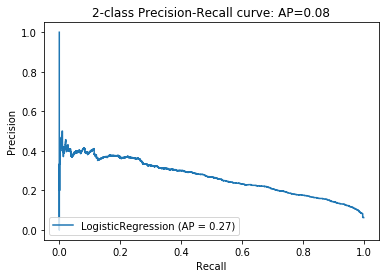

In [373]:
THRESHOLD = 0.005
y_pred = np.where(log_clf.predict_proba(x_cv)[:,1] > THRESHOLD, 1, 0)
print(len(X))
#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y_cv, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y_cv,y_pred)
log_recall = recall_score(y_cv, y_pred)
log_precision = precision_score(y_cv,y_pred)
print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
print(f"The confusion matrix is \n {confusion_matrix(y_cv,y_pred)}")


y_proba = log_clf.predict_proba(x_cv)
from sklearn.metrics import precision_recall_curve
#precision, recall, thresholds = precision_recall_curve(y_cv, y_proba)

from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_cv, y_pred)

disp = plot_precision_recall_curve(log_clf, x_cv, y_cv)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))



misclassified = np.where(y_cv != y_pred)

In [375]:
THRESHOLD = 0.05
y_pred = np.where(log_clf.predict_proba(x_t1a)[:,1] > THRESHOLD, 1, 0)
#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y1a, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y1a,y_pred)
log_recall = recall_score(y1a, y_pred)
log_precision = precision_score(y1a,y_pred)
print(f"The T1a precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
print(f"The T1a confusion matrix is \n {confusion_matrix(y1a,y_pred)}\n\n\n")

y_pred = np.where(log_clf.predict_proba(x_t1b)[:,1] > THRESHOLD, 1, 0)
#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y1b, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y1b,y_pred)
log_recall = recall_score(y1b, y_pred)
log_precision = precision_score(y1b,y_pred)
print(f"The T1b precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
print(f"The T1b confusion matrix is \n {confusion_matrix(y1b,y_pred)}\n\n\n")


y_pred = np.where(log_clf.predict_proba(x_t2a)[:,1] > THRESHOLD, 1, 0)
#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y2a, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y2a,y_pred)
log_recall = recall_score(y2a, y_pred)
log_precision = precision_score(y2a,y_pred)
print(f"The T2a precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
print(f"The T2a confusion matrix is \n {confusion_matrix(y2a,y_pred)}\n\n\n")

y_pred = np.where(log_clf.predict_proba(x_t2b)[:,1] > THRESHOLD, 1, 0)
#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y2b, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y2b,y_pred)
log_recall = recall_score(y2b, y_pred)
log_precision = precision_score(y2b,y_pred)
print(f"The T2b precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
print(f"The T2b confusion matrix is \n {confusion_matrix(y2b,y_pred)}\n\n\n")

y_pred = np.where(log_clf.predict_proba(x_t3a)[:,1] > THRESHOLD, 1, 0)
#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y3a, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y3a,y_pred)
log_recall = recall_score(y3a, y_pred)
log_precision = precision_score(y3a,y_pred)
print(f"The T3a precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
print(f"The T3a confusion matrix is \n {confusion_matrix(y3a,y_pred)}\n\n\n")

y_pred = np.where(log_clf.predict_proba(x_t3b)[:,1] > THRESHOLD, 1, 0)
#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y3b, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y3b,y_pred)
log_recall = recall_score(y3b, y_pred)
log_precision = precision_score(y3b,y_pred)
print(f"The T3b precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
print(f"The T3b confusion matrix is \n {confusion_matrix(y3b,y_pred)}\n\n\n")









0.9671512176703795
The T1a precision is 0.017857142857142856, the recall is 0.25, and the f1 score is 0.03333333333333333
The T1a confusion matrix is 
 [[5120  165]
 [   9    3]]



0.8500956836062088
The T1b precision is 0.08513708513708514, the recall is 0.45384615384615384, and the f1 score is 0.14337788578371813
The T1b confusion matrix is 
 [[3939  634]
 [  71   59]]



0.4076923076923077
The T2a precision is 0.12316176470588236, the recall is 0.8626609442060086, and the f1 score is 0.2155495978552279
The T2a confusion matrix is 
 [[ 806 1431]
 [  32  201]]



0.2621184919210054
The T2b precision is 0.15145228215767634, the recall is 0.9733333333333334, and the f1 score is 0.2621184919210054
The T2b confusion matrix is 
 [[ 73 409]
 [  2  73]]



0.21793534932221065
The T3a precision is 0.1668520578420467, the recall is 0.9933774834437086, and the f1 score is 0.2857142857142857
The T3a confusion matrix is 
 [[ 59 749]
 [  1 150]]



0.199203187250996
The T3b precision is 0.1916890

In [302]:
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

super_misclassified = np.where(y_proba[:][:,1] < 0.10)

x_features = x_miss[super_misclassified]

len(x_features)

#
#import seaborn as sns
##y_proba[:][:,0]
#sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

#min(y_proba[:][:,1])
#min(y_proba[:][:,0])

5554

In [303]:
print(confusion_matrix(y_cv, y_pred))


ValueError: Found input variables with inconsistent numbers of samples: [15805, 745]

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_train)
gnb_score = accuracy_score(y_train, y_pred)
print(gnb_score)
#print(y_test)
gnb_f1 = f1_score(y_train,y_pred)
gnb_recall = recall_score(y_train, y_pred)
gnb_precision = precision_score(y_train,y_pred)
print(f"The precision is {gnb_precision}, the recall is {gnb_recall}, and the f1 score is {gnb_f1}")
print(confusion_matrix(y_train, y_pred))

y_pred = gnb.fit(x_train, y_train).predict(x_cv)
gnb_score = accuracy_score(y_cv, y_pred)
print(gnb_score)
#print(y_test)
gnb_f1 = f1_score(y_cv,y_pred)
gnb_recall = recall_score(y_cv, y_pred)
gnb_precision = precision_score(y_cv,y_pred)
print(f"The precision is {gnb_precision}, the recall is {gnb_recall}, and the f1 score is {gnb_f1}")
print(confusion_matrix(y_cv, y_pred))

misclassified = np.where(y_cv != y_pred)
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

import seaborn as sns
#y_proba[:][:,0]
sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

print(min(y_proba[:][:,1]))
print(min(y_proba[:][:,0]))

In [ ]:
##Prone to Overfitting

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42, max_depth = 15)
tree.fit(x_train, y_train)

y_pred = tree.predict(x_train)
tree_score = accuracy_score(y_train, y_pred)
print(tree_score)
#print(y_test)
tree_f1 = f1_score(y_train,y_pred)
tree_recall = recall_score(y_train, y_pred)
tree_precision = precision_score(y_train,y_pred)
print(f"The precision is {tree_precision}, the recall is {tree_recall}, and the f1 score is {tree_f1}")
print(confusion_matrix(y_train, y_pred))

y_pred = tree.predict(x_cv)
tree_score = accuracy_score(y_cv, y_pred)
print(tree_score)
#print(y_test)
tree_f1 = f1_score(y_cv,y_pred)
tree_recall = recall_score(y_cv, y_pred)
tree_precision = precision_score(y_cv,y_pred)
print(f"The precision is {tree_precision}, the recall is {tree_recall}, and the f1 score is {tree_f1}")
print(confusion_matrix(y_cv, y_pred))

misclassified = np.where(y_cv != y_pred)
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

import seaborn as sns
#y_proba[:][:,0]
sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

print(min(y_proba[:][:,1]))
print(min(y_proba[:][:,0]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

depth = [10, 20, 30]

for d in depth:

    forest = RandomForestClassifier(max_depth = d,random_state=42)
    forest.fit(x_train,y_train)
    y_pred = forest.predict(x_train)
    forest_score = accuracy_score(y_train, y_pred)
    print(tree_score)
    #print(y_test)
    forest_f1 = f1_score(y_train,y_pred)
    forest_recall = recall_score(y_train, y_pred)
    forest_precision = precision_score(y_train,y_pred)
    print(f"The precision is {forest_precision}, the recall is {forest_recall}, and the f1 score is {forest_f1} for depth {d}")
    print(confusion_matrix(y_train, y_pred))
    
    y_pred = forest.predict(x_cv)
    forest_score = accuracy_score(y_cv, y_pred)
    print(forest_score)
    #print(y_test)
    forest_f1 = f1_score(y_cv,y_pred)
    forest_recall = recall_score(y_cv, y_pred)
    forest_precision = precision_score(y_cv,y_pred)
    print(f"The precision is {forest_precision}, the recall is {forest_recall}, and the f1 score is {forest_f1} for depth {d}")
    print(confusion_matrix(y_cv, y_pred))
    misclassified = np.where(y_cv != y_pred)
    x_miss = x_cv[misclassified]
    y_proba = log_clf.predict_proba(x_miss)

    import seaborn as sns
#y_proba[:][:,0]
    sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

    print(min(y_proba[:][:,1]))
    print(min(y_proba[:][:,0]))



In [ ]:
# import tensorflow as tf # Note that tf is the standard way to import tensorflow, much like pd is to pandas
# from tensorflow import keras

# # The code to build the neural network architecture. 

# # We will use the Keras sequential API to build the neural network one layer at a time
# NN = keras.models.Sequential()

# # Next add an input layer
# # '.Flatten' tells keras to reshape the data with this layer and not transform the inputs
# # We specified the input shape as [28,28] since that is the dimensions of our input arrays
# #print(len(x_train), len(x_train[0]))
# NN.add(keras.layers.Flatten(input_shape=(len(x_train[0]),)))

# # Make the hidden layers
# # The '.Dense' part just tells keras/tensorflow that this is just a regular densely connected layer.
# NN.add(keras.layers.Dense(10, activation='relu'))
# NN.add(keras.layers.Dense(5, activation='relu'))

# # Lastly add the output layer
# # Remember to specify the softmax activation function
# NN.add(keras.layers.Dense(2, activation='sigmoid'))

In [ ]:
#NN.summary()

In [ ]:
# weights, biases = NN.layers[1].get_weights()

In [ ]:
# #from keras.optimizers import SGD
# opt = keras.optimizers.SGD(learning_rate=0.1)
#  NN.compile(loss = 'sparse_categorical_crossentropy', # This is explained much more below
#           optimizer = opt, # sgd stands for stochastic gradient descent
#           metrics = ['accuracy']) # These are other metrics you would like to calculate after each epoch

In [ ]:
# history = NN.fit(x_train, y_train, epochs = 30,
#                  validation_data = (x_cv, y_cv))

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

# pd.DataFrame(history.history).plot(figsize=(8,5))
# plt.grid(True)
# plt.gca().set_ylim(0,1)
# plt.show();

# Undersampling the classes + single data set

In [ ]:
X = new_df[attribs]
y = new_df['CS_LYMPH_NODE_METS']
healthy_idx = new_df[new_df['CS_LYMPH_NODE_METS'] == 0.0].index
#print(len(healthy_idx))
#print(len(y))
random_idx = np.random.choice(healthy_idx, 10000, replace=False)
##print(len(random_idx))

sick_idx = new_df[new_df['CS_LYMPH_NODE_METS'] == 1.0].index
all_idx = np.concatenate((random_idx, sick_idx), axis = None)

X = X.loc[all_idx]
y = y.loc[all_idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.10, random_state=20)

x_train = preprocess_pipeline.fit_transform(X_train)
x_train
x_cv = preprocess_pipeline.transform(X_cv)
x_test = preprocess_pipeline.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

log_clf = LogisticRegression(solver="liblinear")
log_clf.fit(x_train,y_train)


log_scores = cross_val_score(log_clf, x_train,y_train,cv=10,scoring="accuracy")
print(min(log_scores))

importance = log_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))


In [ ]:
THRESHOLD = [0.1, 0.15, 0.2]
for thresh in THRESHOLD:
    print(f"THRESHOLD is {thresh}")
    y_pred = np.where(log_clf.predict_proba(x_train)[:,1] > thresh, 1, 0)
    log_score = accuracy_score(y_train,y_pred)
    print(log_score)
    log_scores.mean()
    print(confusion_matrix(y_train, y_pred))
#y_pred = y_pred == 2
#y_simple = y_train == 2
    log_f1 = f1_score(y_train,y_pred)
    log_recall = recall_score(y_train, y_pred)
    log_precision = precision_score(y_train,y_pred)
    print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}\n\n\n")

In [ ]:
#x_test = preprocess_pipeline.transform(X_test) #running our train_set through the pipeline
#x_test = sc.transform (x_test)
for thresh in THRESHOLD:
    print(f"THRESHOLD is {thresh}")

    y_pred = np.where(log_clf.predict_proba(x_cv)[:,1] > thresh, 1, 0)

#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
    log_score = accuracy_score(y_cv, y_pred)
    print(log_score)
#print(y_test)
    log_f1 = f1_score(y_cv,y_pred)
    log_recall = recall_score(y_cv, y_pred)
    log_precision = precision_score(y_cv,y_pred)
    print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
    print(f"The confusion matrix is \n {confusion_matrix(y_cv,y_pred)}\n\n\n")


#y_proba = log_clf.predict_proba(x_cv)
#from sklearn.metrics import precision_recall_curve
##precision, recall, thresholds = precision_recall_curve(y_cv, y_proba)
#
#from sklearn.metrics import plot_precision_recall_curve
#import matplotlib.pyplot as plt
#from sklearn.metrics import average_precision_score
#average_precision = average_precision_score(y_cv, y_pred)
#
#disp = plot_precision_recall_curve(log_clf, x_cv, y_cv)
#disp.ax_.set_title('2-class Precision-Recall curve: '
#                   'AP={0:0.2f}'.format(average_precision))
#
#
#
#misclassified = np.where(y_cv != y_pred)

# adding in more data rofl hahaha this definitely works


In [ ]:
new_mela = pd.read_csv('seer_melanoma.csv')
new_mela = new_mela.rename(columns={'CS_SITESPECIFIC_FACTOR_1': "DEPTH", 'CS_SITESPECIFIC_FACTOR_2': 'ULCERATION',
       'CS_SITESPECIFIC_FACTOR_7': 'MITOSES', 'CS_SITESPECIFIC_FACTOR_3': 'CS_LYMPH_NODE_METS'})
attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION',
        'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'CS_LYMPH_NODE_METS']

new_data = new_mela[attribs].dropna()


#### NEW SECTION
#new_data['CS_LYMPH_NODE_METS'] = new_data['CS_LYMPH_NODE_METS'].replace([5, 10],[0, 1])
#new_data = new_data[new_data['CS_LYMPH_NODE_METS'] <= 1.5]
#data['CS_LYMPH_NODE_METS'].value_counts()
#import numpy as np
#data['TNM_PATH_N'] = data['TNM_PATH_N'].replace(['p0', 'pX', 'p1A', 'p2A', 'p1', 'p3', 'p2C', 'p2', 'p1B', 'p2B', '88'], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

#new_data['REGIONAL_NODES_POSITIVE'] = new_data['REGIONAL_NODES_POSITIVE'].replace([98, 99], [0, 0])
#new_data['POSITIVE'] = np.where(new_data['TNM_PATH_N'] + new_data['CS_LYMPH_NODE_METS'] + new_data['REGIONAL_NODES_POSITIVE'] > 0, 1, 0)

### END OF NEW SECTION

df = new_data[(new_data != 999).all(1)]
df = df[df['MITOSES'] != 988]
df = df.dropna()
df = df[(df != 1022).all(1)]
df['ULCERATION'] = df['ULCERATION'].replace(10, 1)

df['CS_EXTENSION'].value_counts()
df['CS_EXTENSION'] = df['CS_EXTENSION'].replace([
    310, 315, 320, 330, 335, 340, 350, 355, 360, 370, 375, 380, 400, 950],
    [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,  999])
df = df[(df != 999).all(1)]
df = df[df['AGE'] <= 84]
df['CS_LYMPH_NODE_METS'] = df['CS_LYMPH_NODE_METS'].replace([5, 10],[0, 1])
df = df[df['CS_LYMPH_NODE_METS'] <= 1.5]
df['CS_LYMPH_NODE_METS'].value_counts()
print(df['PRIMARY_SITE'].value_counts())
df['PRIMARY_SITE'] = df['PRIMARY_SITE'].replace([
    440, 441, 442, 443, 444, 445, 446, 447, 448, 449],  [0,0,0,0,0,1, 2,2,999,999])
print(df['PRIMARY_SITE'].value_counts())
df = df[(df != 999).all(1)]
df = df[df['MITOSES'] <= 11]

#print(df.describe())
#print(new_df.describe())

In [ ]:
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'DEPTH', 'DEPTH_3', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE']

attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION',
            'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE']
#print(new_df.describe())
concat_data = pd.concat([new_df, df])
print(concat_data.describe())
#X = new_df[attribs]
X = concat_data[attribs]
#y = new_df['CS_LYMPH_NODE_METS']
y = concat_data['CS_LYMPH_NODE_METS']
#y = new_df['REGIONAL_NODES_POSITIVE']
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.10, random_state=20)

In [ ]:
x_train = preprocess_pipeline.fit_transform(X_train)
x_train
x_cv = preprocess_pipeline.transform(X_cv)
x_test = preprocess_pipeline.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

log_clf = LogisticRegression(solver="liblinear", class_weight="balanced")
log_clf.fit(x_train,y_train)


log_scores = cross_val_score(log_clf, x_train,y_train,cv=10,scoring="accuracy")
print(min(log_scores))

In [ ]:
THRESHOLD = 0.03
y_pred = np.where(log_clf.predict_proba(x_train)[:,1] > THRESHOLD, 1, 0)
log_score = accuracy_score(y_train,y_pred)
print(log_score)
log_scores.mean()
print(f"The confusion matrix is {confusion_matrix(y_train,y_pred)}")
importance = log_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
#y_pred = y_pred == 2
#y_simple = y_train == 2
log_f1 = f1_score(y_train,y_pred)
log_recall = recall_score(y_train, y_pred)
log_precision = precision_score(y_train,y_pred)
print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")

In [ ]:
#x_test = preprocess_pipeline.transform(X_test) #running our train_set through the pipeline
#x_test = sc.transform (x_test)
#THRESHOLD = 0.001
y_pred = np.where(log_clf.predict_proba(x_cv)[:,1] > THRESHOLD, 1, 0)

#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y_cv, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y_cv,y_pred)
log_recall = recall_score(y_cv, y_pred)
log_precision = precision_score(y_cv,y_pred)
print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
print(f"The confusion matrix is \n {confusion_matrix(y_cv,y_pred)}")


y_proba = log_clf.predict_proba(x_cv)
from sklearn.metrics import precision_recall_curve
#precision, recall, thresholds = precision_recall_curve(y_cv, y_proba)

from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_cv, y_pred)

disp = plot_precision_recall_curve(log_clf, x_cv, y_cv)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))



misclassified = np.where(y_cv != y_pred)

# Undersampling + 2 data sets

In [ ]:
X = concat_data[attribs]
y = concat_data['CS_LYMPH_NODE_METS']
healthy_idx = concat_data[concat_data['CS_LYMPH_NODE_METS'] == 0.0].index
#print(len(healthy_idx))
#print(len(y))
random_idx = np.random.choice(healthy_idx, 12000, replace=False)
##print(len(random_idx))

sick_idx = concat_data[concat_data['CS_LYMPH_NODE_METS'] == 1.0].index
all_idx = np.concatenate((random_idx, sick_idx), axis = None)

X = X.loc[all_idx]
y = y.loc[all_idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.10, random_state=20)

x_train = preprocess_pipeline.fit_transform(X_train)
x_train
x_cv = preprocess_pipeline.transform(X_cv)
x_test = preprocess_pipeline.transform(X_test)


In [ ]:
log_clf = LogisticRegression(solver="liblinear")
log_clf.fit(x_train,y_train)


log_scores = cross_val_score(log_clf, x_train,y_train,cv=10,scoring="accuracy")
print(min(log_scores))


importance = log_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
THRESHOLD = [0.01, 0.02, 0.03, 0.04, 0.05]
for thresh in THRESHOLD:
    print(f"THRESHOLD is {thresh}")
    y_pred = np.where(log_clf.predict_proba(x_train)[:,1] > thresh, 1, 0)
    log_score = accuracy_score(y_train,y_pred)
    print(log_score)
    log_scores.mean()
    print(confusion_matrix(y_train, y_pred))
#y_pred = y_pred == 2
#y_simple = y_train == 2
    log_f1 = f1_score(y_train,y_pred)
    log_recall = recall_score(y_train, y_pred)
    log_precision = precision_score(y_train,y_pred)
    print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}\n\n\n")

In [ ]:
#x_test = preprocess_pipeline.transform(X_test) #running our train_set through the pipeline
#x_test = sc.transform (x_test)
for thresh in THRESHOLD:
    print(f"THRESHOLD is {thresh}")

    y_pred = np.where(log_clf.predict_proba(x_cv)[:,1] > thresh, 1, 0)

#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
    log_score = accuracy_score(y_cv, y_pred)
    print(log_score)
#print(y_test)
    log_f1 = f1_score(y_cv,y_pred)
    log_recall = recall_score(y_cv, y_pred)
    log_precision = precision_score(y_cv,y_pred)
    print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")
    print(f"The confusion matrix is \n {confusion_matrix(y_cv,y_pred)}\n\n\n")